In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from pathlib import Path
import gc
import pickle as pkl
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

import time
from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.set_random_seed(368)

Using TensorFlow backend.


In [2]:
DEMO_CV = False
DO_TRAIN = True

DATA = Path('../Data')

# Load Data

In [3]:
%time train_df = pd.read_csv(DATA/'train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

Wall time: 1min 48s


In [4]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [5]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

In [9]:
X_train_mean = np.mean(X_train) # cheating vs. validation, but assumed to be negligible.
X_train_std = np.std(X_train)
print(X_train_mean, X_train_std)

4.512620241664933 6.187129402153584


# CV & Sampler

Note:
- Outer CV of 5 folds.
- Inner early-stopping without CV - simply first 80% segments to train & last 20% to early stopping group.
- Sampling within train data is uniformly-random over all its segments.

In [10]:
def stratified_group_k_fold(X, y, groups, k, seed=42):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

   i   start  fold                              time
0  0       0   0.0  1.430797219276428222656250000000
1  1   25000   0.0  1.424496769905090332031250000000
2  2   50000   0.0  1.418096303939819113892895074969
3  3   75000   0.0  1.411695837974548339843750000000
4  4  100000   0.0  1.404199838638305664062500000000
           i      start  fold                             time
21983  21983  628760672   0.0  9.82039737701416015625000000000
21984  21984  628785672   0.0  9.81399631500243962989316059975
21985  21985  628810672   0.0  9.80769634246826171875000000000
21986  21986  628835672   0.0  9.80129528045654296875000000000
21987  21987  628985672   0.0  9.76189708709716796875000000000


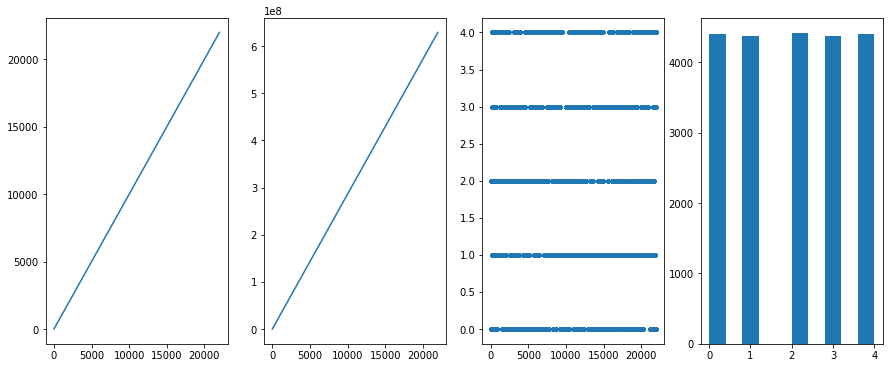

In [11]:
N_FOLDS = 5
np.random.seed(368)
tf.set_random_seed(368)

if DEMO_CV:
    N_SEGS = 500
    FOLDS = pd.DataFrame({'i':np.arange(N_SEGS), 'start':np.arange(0,N_SEGS*50000,50000),
                         'fold':np.repeat(np.arange(5),N_SEGS//N_FOLDS)})
    print(FOLDS.head())
    print(FOLDS.tail())

else:
#     meta = pd.read_pickle('train.meta.covs.pickle')
#     meta['i'] = list(range(len(meta)))
#     starts = np.array([x[0] for x in train_segments] + [train_segments[-1][1]])
#     meta['start'] = meta.seg + starts[meta.cycle]
#     iterator = stratified_group_k_fold(meta, pd.qcut(meta['qt'],10,labels=range(10)), groups=meta['group'], k=N_FOLDS, seed=25)
#     for f, (dev_index, val_index) in enumerate(iterator):
#         meta.loc[val_index,'fold'] = f
#     FOLDS = meta[['i','start','fold']]
#     FOLDS['time'] = [y_train[i+150000-1] for i in FOLDS.start]
#     FOLDS.to_csv('folds.csv', index=False)
    
    FOLDS = pd.read_csv('folds.csv')
    
    fig,axs = plt.subplots(1,4, figsize=(15,6))
    axs[0].plot(FOLDS.i)
    axs[1].plot(FOLDS.start)
    axs[2].plot(FOLDS.fold, '.')
    axs[3].hist(FOLDS.fold)
    
    print(FOLDS.head())
    print(FOLDS.tail())

C:\Users\idogr\Anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


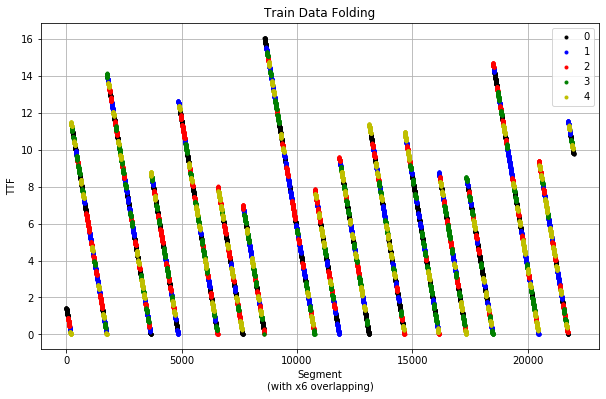

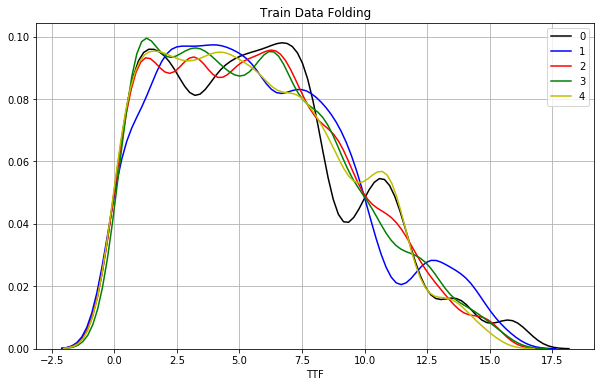

In [12]:
def plot_folds(meta, K_FOLDS=None, COLORS = ('k','b','r','g','y')):
    if K_FOLDS is None:
        K_FOLDS = len(np.unique(meta.fold))
    
    plt.figure(figsize=(10,6))
    for k in range(K_FOLDS):
        plt.plot(np.argwhere(meta.fold==k), meta.loc[meta.fold==k,'time'], COLORS[k]+'.', label=k)
    plt.xlabel('Segment\n(with x6 overlapping)')
    plt.ylabel('TTF')
    plt.title('Train Data Folding')
    plt.grid()
    plt.legend()
    
    plt.figure(figsize=(10,6))
    for k in range(K_FOLDS):
        sns.distplot(meta.loc[meta.fold==k,'time'], color=COLORS[k], hist=False, label=k)
    plt.xlabel('TTF')
    plt.title('Train Data Folding')
    plt.legend()
    plt.grid()

plot_folds(FOLDS)

In [13]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch, validation=False):
        self.x = x
        self.y = y
        self.segments = segments # indices of starts of 150K-long segments
        self.ts_length = ts_length # 150K
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.x_mean = x_mean
        self.x_std = x_std
        self.validation = validation

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx, high_res=True):
        # just ignore self.segments and pick bacth_size random offsets from all data
        segments = np.random.randint(0, len(self.y)-self.ts_length, size=self.batch_size)
        
        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, start in enumerate(segments):
            x_batch[i, :] = self.x[start : start + self.ts_length]
            y_batch[i] = self.y[start + self.ts_length - 1]
            
        x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

# Define Transformer Model

Use convolutional layers to learn the features and reduce the time sequence length 

In [14]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

In [15]:
def CnnTransformerModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D( 8, kernel_size = 10, strides = 10, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
   # x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    
    y = Dense(1)(avg_pool)
    

    return Model(inputs = [i], outputs = [y])

# Train & Test on each Fold

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
--- 61.74286534786224 minutes ---


55

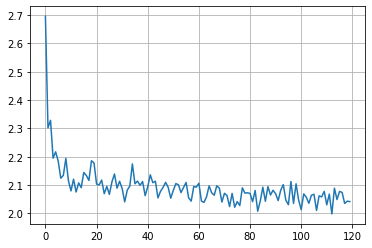

In [21]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = None,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 72 # 300 # 400
)

# Initialize model
model = CnnTransformerModel()
model.compile(loss='mean_absolute_error', optimizer='adam')

# Train
if DO_TRAIN:
    start_time = time.time()
    hist = model.fit_generator(
        generator =  train_gen,
        epochs = 120, # 150,
        verbose = 1
    )
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    model.save_weights(f'./trained_model_full.h5', overwrite=True)

    # Show train stats
    plt.plot(hist.history['loss'], label='Train')
    #ax.plot(hist.history['val_loss'], label='Valid')
    #ax.set_title(f'Model Loss (fold={i:d})')
    #ax.set_ylabel('Loss')
    #ax.set_xlabel('Epoch')
    #ax.legend(loc='upper left')
    plt.grid()
    plt.draw()

else:
    model.load_weights(f'./trained_model_full.h5')
    
    # Run on validation fold
#     valid_starts = FOLDS.loc[FOLDS['fold']==i, 'start'].values
#     valid_segs = np.zeros((len(valid_starts), 150000))
#     for j, seg_start in enumerate(valid_starts):
#         valid_segs[j,:] = X_train[seg_start : seg_start + 150000]
#     valid_segs = ((valid_segs - X_train_mean)/ X_train_std)
#     valid_segs = np.expand_dims(valid_segs, 2)
#     valid_ys = np.array([y_train[seg_start + 150000 - 1] for seg_start in valid_starts])
#     valid_preds = np.squeeze(model.predict(valid_segs))
#     outliers = np.sum(np.logical_or(valid_preds<0, valid_preds>16.5))
#     print(f'Predictions not in [0,16.5]:\t{outliers:d} ({100*outliers/len(valid_preds):.1f}%)')
#     cropped_preds = np.maximum(np.minimum(valid_preds, 16.5), 0)
#     MAE.append(np.mean(np.abs(valid_preds-valid_ys)))
#     print(f'MAE ({i:d}):\t{MAE[-1]:.3f}')
#     preds[FOLDS.loc[FOLDS['fold']==i,'i'].values] = valid_preds

del train_gen
gc.collect()


# with open('transformer_predictions.pkl','wb') as fd:
#     pkl.dump(preds, fd)
# print(f'MAE (Total):\t{np.mean(np.abs(preds-ys)):.3f}')
# print(MAE)

In [22]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15000, 8)     88          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1500, 16)     1296        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 150, 16)      2576        conv1d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

### Some training post analysis

In [23]:
# for var, obj in locals().items():
#     if sys.getsizeof(obj)>1e6:
#         print(var, sys.getsizeof(obj)/1e6)

In [24]:
# get all predictions
preds2 = []
for f in range(5):
    n = int(np.sum(FOLDS.fold==f))
    ts = np.empty([n, 150000])
    for s in range(n):
        start = FOLDS.loc[FOLDS.fold==f,'start'].values[s]
        ts[s, :] = X_train[start:start+150000]
    ts = ((ts - X_train_mean)/ X_train_std)
    ts = np.expand_dims(ts, 2)
    # predict
    preds2.append([])
    preds2[f].append(np.squeeze(model.predict(ts)))

Text(33.0, 0.5, 'Fold')

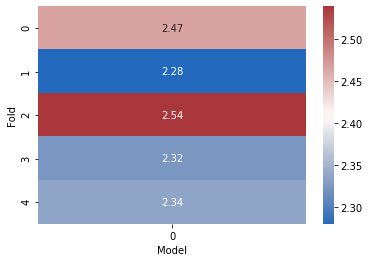

In [26]:
sns.heatmap(np.array([[ np.mean(np.abs(preds2[f][m] - FOLDS[FOLDS.fold==f].time))
                       for m in range(len(preds2[0]))] for f in range(len(preds2))]),
           annot=True, fmt=".2f", cmap=sns.cm.vlag)
plt.xlabel('Model')
plt.ylabel('Fold')

C:\Users\idogr\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\idogr\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


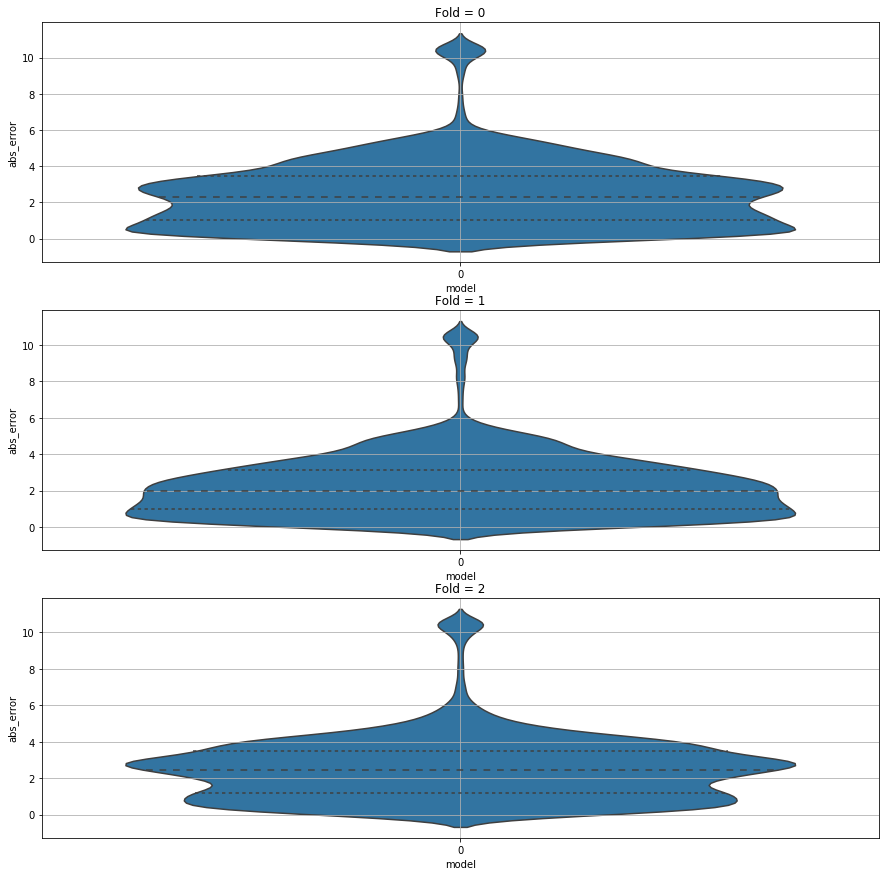

In [27]:
fig, axs = plt.subplots(3,1, figsize=(15,15))

for f in range(3):
    ax = axs[f]
    ax.set_title(f'Fold = {f:d}')
    meta = FOLDS[FOLDS.fold==f]
    meta_all = pd.DataFrame()
    for i,p in enumerate(preds2[f]):
        meta['model'] = i
        meta['abs_error'] = np.abs(p - meta.time)
        meta_all = pd.concat([meta_all,meta])
    sns.violinplot(x='model', y='abs_error', data=meta_all, scale='width', inner="quartile", showmeans=True, ax=ax)
    ax.grid()
#     sns.violinplot(ax=ax, x="", y="Prediction", hue="Model", data=df, order=order,
#                    palette="muted", split=True, scale="width", inner="quartile", showmeans=True)

In [ ]:
del X_train
del y_train
del train_df
gc.collect()

# Run on Test Data

Load and normalize the test data

In [28]:
def load_test(ts_length = 150000):
    base_dir = DATA/'test'
    test_files = [f for f in listdir(base_dir) if isfile(base_dir/f)]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir/f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [29]:
test_data, test_ids = load_test()

In [30]:
X_test = ((test_data - X_train_mean)/ X_train_std)
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

Load best model and predict

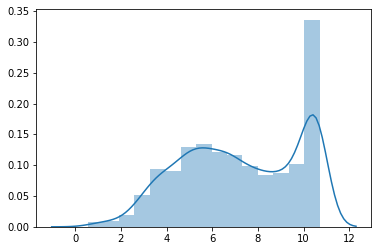

In [31]:
model = CnnTransformerModel()
model.compile(loss='mean_absolute_error', optimizer='adam')
model.load_weights(f'./trained_model_full.h5')
model_preds = np.squeeze(model.predict(X_test))
cropped_preds = np.maximum(np.minimum(model_preds, 16.5), 0)
y_pred = cropped_preds
sns.distplot(y_pred)

In [32]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred})
submission_df.to_csv("submission_transformer.csv", index=False)